In [1]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
using KernelDensity
include("../../Inversion/Plot.jl")
include("../../Inversion/RWMCMC.jl")
include("../../Inversion/SMC.jl")
include("../../Inversion/KalmanInversion.jl")
include("../../Inversion/IPS.jl")

update_ensemble! (generic function with 11 methods)

# 1-Parameter Square Map
The posterior distribution is studied  numerically on the following nonlinear 1-parameter problem:

$$
\begin{equation*}
y = \mathcal{G}(\theta) + \eta \qquad \mathcal{G}(\theta) = \theta^2. 
\end{equation*}
$$    


We assume the observation is $y = 1$ and the piror is $\mathcal{N}(3, 2^2)$, we consider the following cases

$$
\begin{align*}
&A: \eta \sim \mathcal{N}(0, 1^2)\\
&B: \eta \sim \mathcal{N}(0, 0.5^2)\\
&C: \eta \sim \mathcal{N}(0, 0.2^2)\\
\end{align*}
$$ 

In [2]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function p1(s_param, θ)  
    return [θ[1] ;]
end

function p1_aug(s_param, θ)  
    return [θ[1] ; θ[1]]
end

function p1_aug_derivative(s_param, θ)  
    return [θ[1] ; θ[1]], [1.0 ; 1.0]
end



function p2(s_param, θ)  
    return [θ[1]^2 ;]
end

function p2_aug(s_param, θ)  
    return [θ[1]^2 ; θ[1]]
end

function p2_aug_derivative(s_param, θ)  
    return [θ[1]^2 ; θ[1]], [2θ[1] ; 1.0]
end

p2_aug_derivative (generic function with 1 method)

# Numerical Methods

The posterior distribution is approximated by 
* MCMC method (reference):  a step size $1.0$ and $5\times10^6$ samples (with a $10^6$ sample burn-in period).
* SMC method: $10^3$ particles and $10^2$ uniform steps is also applied for comparison. 
* UKI method: $2$ initial conditions are considered, which are $\theta_0\sim\mathcal{N}(-1, 0.5^2)$ and $\theta_0\sim\mathcal{N}(1, 0.5^2)$. We find that only the hyperbola discontinuous problem is sensitive to the initial covariance for the UKI. The hyperparameters of UKI are chosen at the $n$-th iteration, as following
$$ r = r_0 \quad
    \Sigma_{\nu} = 2\Sigma_{\eta} \quad \textrm{ and } \quad \Sigma_{\omega} =  C_n
$$
here $r_0$ is the prior mean. It is worth mentioning the artificial evolution error covariance $\Sigma_{\omega}$ is updated as the estimated covariance $C_{n}$.

In [3]:
function intp_kernel_1d(θ, xx = nothing; Nx=100,  preconditioner=false) 
    
    N_ens, N_θ = size(θ)
    if xx == nothing
        θ_min, θ_max = minimum(θ), maximum(θ)
        xx = reshape(Array(LinRange(θ_min - 0.1*(θ_max - θ_min), θ_max + 0.1*(θ_max - θ_min), Nx)), Nx, 1)
    else
        xx = reshape(xx, length(xx), 1)
    end
    # u_mean: N_par × 1
    θ_mean = construct_mean(θ)
    θθ_cov = construct_cov(θ, θ_mean, θ, θ_mean)
    Prec = (preconditioner ? θθ_cov : I)
    κ = kernel(θ, xx; C = (preconditioner ? θθ_cov : nothing) )
    
    xx = xx[:]
    yy = sum(κ, dims=1)[:]
    yy /= sum(yy)*(xx[2] - xx[1])
    return xx, yy
end



function Posterior_Plot(forward::Function;  θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, 
                        Run_EKS = false, Run_SMC = false, Run_MCMC = false, Run_Fisher_Rao =false, plot_every = 1)

    forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)
    
    N_y, N_θ = 1, 1
    s_param = Setup_Param(N_θ, N_y)
    y = forward(s_param, [θ_ref;])
    Σ_η = reshape([σ_η^2], (N_y, N_y))
    # prior distribution
    μ0,  Σ0   = [μ_0;], reshape([σ_0^2],  (N_θ, N_θ))
    
    
    
    

    # compute posterior distribution by UKI
    update_freq = 1
    N_iter = 30
    
    s_param_aug = Setup_Param(1,2)
    y_aug = [y ; μ0]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    γ = 1.0
    
    ukiobjs = [] 
    for N_modes = 1:3
        
        θ0_w  = fill(1.0, N_modes)/N_modes
        θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)

        Random.seed!(111);
        for m = 1:N_modes
            θ0_mean[m, :]    .= rand(Normal(0, σ_0), N_θ)
            θθ0_cov[m, :, :] .= Array(Diagonal(fill(σ_0^2, N_θ)))
        end
        @info "Run GMKI with ", N_modes, " θ0_mean = ", θ0_mean
        ukiobj = GMUKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, update_freq, N_iter; unscented_transform="modified-2n+1")
        push!(ukiobjs, ukiobj) 
    
    end


    if Run_MCMC
        # compute posterior distribution by MCMC
        logρ(θ) = log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0) 
        step_length = 1.0
        n_iter , n_burn_in= 5000000, 1000000
        us = RWMCMC_Run(logρ, μ0, step_length, n_iter)
    end
    
    # compute posterior distribution by SMC
    if Run_SMC
        N_ens = 100
        M_threshold = Float64(N_ens)
        step_length = 1.0
        smcobj = SMC_Run(s_param, forward,
        μ0, Σ0, 
        y, Σ_η,
        N_ens, 
        step_length,
        M_threshold,
        N_iter) 
    end

    if Run_EKS
        N_ens  = 1000
        eksobj = EKS_Run(s_param, forward, 
        μ0, Σ0,
        N_ens,
        y, Σ_η,
        N_iter)
        @info "EKS large J t = ", sum(eksobj.Δt)
    end
    
    if Run_Fisher_Rao
        N_ens  = 100
        method  = "Wasserstein"
        preconditioner = true             # true
        Δt, N_t = 1e-3/5, 100
        
        logρ = θ ->log_bayesian_posterior(s_param, θ, forward, y, Σ_η, μ0, Σ0)
        
        function compute_∇logρ(s_param, θ)
            return logρ(θ), ForwardDiff.gradient(logρ, θ)
        end   
        θ0 = Array(rand(MvNormal(μ0, Σ0), N_ens)')   
        ipsobj = IPS_Run(s_param, compute_∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner)
        
    end
    
        
    Nx = 1000
    θ_min = minimum(ukiobjs[end].θ_mean[end][:,1] .- 5sqrt.(ukiobjs[end].θθ_cov[end][:,1,1]))
    θ_max = maximum(ukiobjs[end].θ_mean[end][:,1] .+ 5sqrt.(ukiobjs[end].θθ_cov[end][:,1,1]))

    # Plot reference
    xx_ref = Array(LinRange(θ_min, θ_max, 1000))
    yy_ref = copy(xx_ref)
    for i = 1:length(xx_ref)
        y_pred = forward(s_param, [xx_ref[i];])[1]
        yy_ref[i] = exp( - 0.5*(y_pred - y[1])^2/σ_η^2  - 0.5*(xx_ref[i] - μ_0)^2/σ_0^2 )
    end
    yy_ref .= yy_ref / ( sum(yy_ref)*(xx_ref[2] - xx_ref[1]) )
           
    
    
    # visualization 
    plot_every = 10
    linestyles = ["o"; "x"; "s"]
    # Visualize different iterations
    for iter  = [1:plot_every:N_iter; N_iter]
        nrows, ncols = 2, 3
        fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=false, sharey="row", figsize=(15,10))
        
        
        # plot UKI results 
        for N_modes = 1:3
            
            # Plot reference
            ax[1, N_modes].plot(xx_ref, yy_ref, "-s", label="Reference", color="grey", linewidth=2, fillstyle="none", markevery=25)
           
            
            
            if Run_MCMC
                # plot MCMC results 
                ax[1, N_modes].hist(us[n_burn_in:end, 1], bins = 100, density = true, histtype = "step", label="MCMC", color="grey", linewidth=2)
            end


            if Run_SMC
                # plot SMC results 
                θ = smcobj.θ[end]
                weights = smcobj.weights[end]
                ax[1, N_modes].hist(θ, bins = 10, weights = weights, density = true, histtype = "step", label="SMC", color="maroon")  
            end
            
            
            if Run_EKS
                # plot EKS results 
                θ = eksobj.θ[end]
                ax[1, N_modes].hist(θ, bins = 40, density = true, histtype = "step", label="EKS", color="C4")
            end

            
            if Run_Fisher_Rao
                # plot EKS results 
                θ = ipsobj.θ[end]
                xx_FR, yy_FR = intp_kernel_1d(θ, xx_ref)
                ax[1, N_modes].plot(xx_FR, yy_FR, "--", label="WFR", color="C5")
                
                @info "L2 error = ", norm(yy_ref - yy_FR, 1)*(xx_FR[2] - xx_FR[1])
            end
            
            
            
            Nx = 1000
            xxs, zzs = zeros(N_modes, Nx), zeros(N_modes, Nx)
            θ_min = minimum(ukiobjs[N_modes].θ_mean[iter][:,1] .- 5sqrt.(ukiobjs[N_modes].θθ_cov[iter][:,1,1]))
            θ_max = maximum(ukiobjs[N_modes].θ_mean[iter][:,1] .+ 5sqrt.(ukiobjs[N_modes].θθ_cov[iter][:,1,1]))            
            
            
            for i =1:N_modes
                xxs[i, :], zzs[i, :] = Gaussian_1d(ukiobjs[N_modes].θ_mean[iter][i,1], ukiobjs[N_modes].θθ_cov[iter][i,1,1], Nx, θ_min, θ_max)
                zzs[i, :] *= exp(ukiobjs[N_modes].logθ_w[iter][i])
                
                ax[1, N_modes].plot(fill(ukiobjs[N_modes].θ_mean[iter][i,1], 11), LinRange(0,1,11), marker=linestyles[i], fillstyle="none", markevery=5, color="C"*string(i))


                # ax[1, N_modes].plot(xxs[i,:], zzs[i,:], marker= linestyles[i], linestyle=":", color="C"*string(i), fillstyle="none", markevery=100, label="modal "*string(i))
            end
            ax[1, N_modes].plot(xxs[1,:], sum(zzs, dims=1)', linestyle="-", color="C0", fillstyle="none", markevery=100, label="GMKI", linewidth=2)
        


            ax[1, N_modes].legend()
            
            
            θ_w = exp.(hcat(ukiobjs[N_modes].logθ_w...))
            for i =1:N_modes
                ax[2, N_modes].plot(Array(1:N_iter), θ_w[i, 1:N_iter], marker=linestyles[i], color = "C"*string(i), fillstyle="none", markevery=5, label= "mode "*string(i))
            end
            ax[2, N_modes].legend()
            ax[2, N_modes].set_xlabel("Iterations")
        end
        ax[1, 1].set_ylabel("Densities")
        ax[2, 1].set_ylabel("Weights")
        
        fig.tight_layout()
        fig.savefig("1D-density-"*string(σ_η)*"-"*string(iter)*".pdf")
    end
    
    
    
end

Posterior_Plot (generic function with 1 method)

In [4]:
Error table （100particles, dt=1e-3, Nt=100）

Wasserstein
NaNs                   0.6289606421630689    1.1972859350483611     1.3172102662545384
Affine-invariant Wasserstein
NaNs                   NaNs                  1.2923829825278892     1.2679882724407348
Wasserstein-Fisher-Rao
0.19411696215490884    0.3277327113419347    0.7458465312125258     0.8192975340215664
Affine-invariant Wasserstein-Fisher-Rao
NaNs                   0.5152754288887108    0.8436443101135377     0.8751082204107593
Affine-invariant Wasserstein-Fisher-Rao (Stein kernel)
NaNs                   0.5076309298880499    0.8389674032560562     0.8569556666378838

Stein
0.5655703388714324     0.444667683639532     0.7833747505005163     0.9263710300425374
Affine-invariant Stein
NaNs                   0.6215487061447607    0.33228804319328353    0.4081386894453606
Stein-Fisher-Rao
0.3254841264015533     0.31296640923609054   0.525684200013725      0.6463016679512523
Affine-invariant Wasserstein-Fisher-Rao  
NaNs                   0.4122580486902555    0.36384481929219675    0.5126416178914104
Affine-invariant Wasserstein-Fisher-Rao (Stein kernel)
NaNs                   0.4261500700985909    0.3656169608755228     0.5126416178914104




Error table （100particles, dt=1e-3, Nt=100）
Wasserstein
NaNs                   0.6289606421630689    1.1972859350483611     1.3172102662545384
Affine-invariant Wasserstein
NaNs                   NaNs                  1.2923829825278892     1.2679882724407348
Wasserstein-Fisher-Rao
0.19411696215490884    0.3277327113419347    0.7458465312125258     0.8192975340215664
Affine-invariant Wasserstein-Fisher-Rao
NaNs                   0.5152754288887108    0.8436443101135377     0.8751082204107593
Affine-invariant Wasserstein-Fisher-Rao (Stein kernel)
NaNs                   0.5076309298880499    0.8389674032560562     0.8569556666378838

Stein
0.5655703388714324     0.444667683639532     0.7833747505005163     0.9263710300425374
Affine-invariant Stein
NaNs                   0.6215487061447607    0.33228804319328353    0.4081386894453606
Stein-Fisher-Rao
0.3254841264015533     0.31296640923609054   0.525684200013725      0.6463016679512523
Affine-invariant Wasserstein-Fisher-Rao  
NaNs                   0.4122580486902555    0.36384481929219675    0.5126416178914104
Affine-invariant Wasserstein-Fisher-Rao (Stein kernel)
NaNs                   0.4261500700985909    0.3656169608755228     0.5126416178914104

LoadError: syntax: extra token "table" after end of expression

┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82


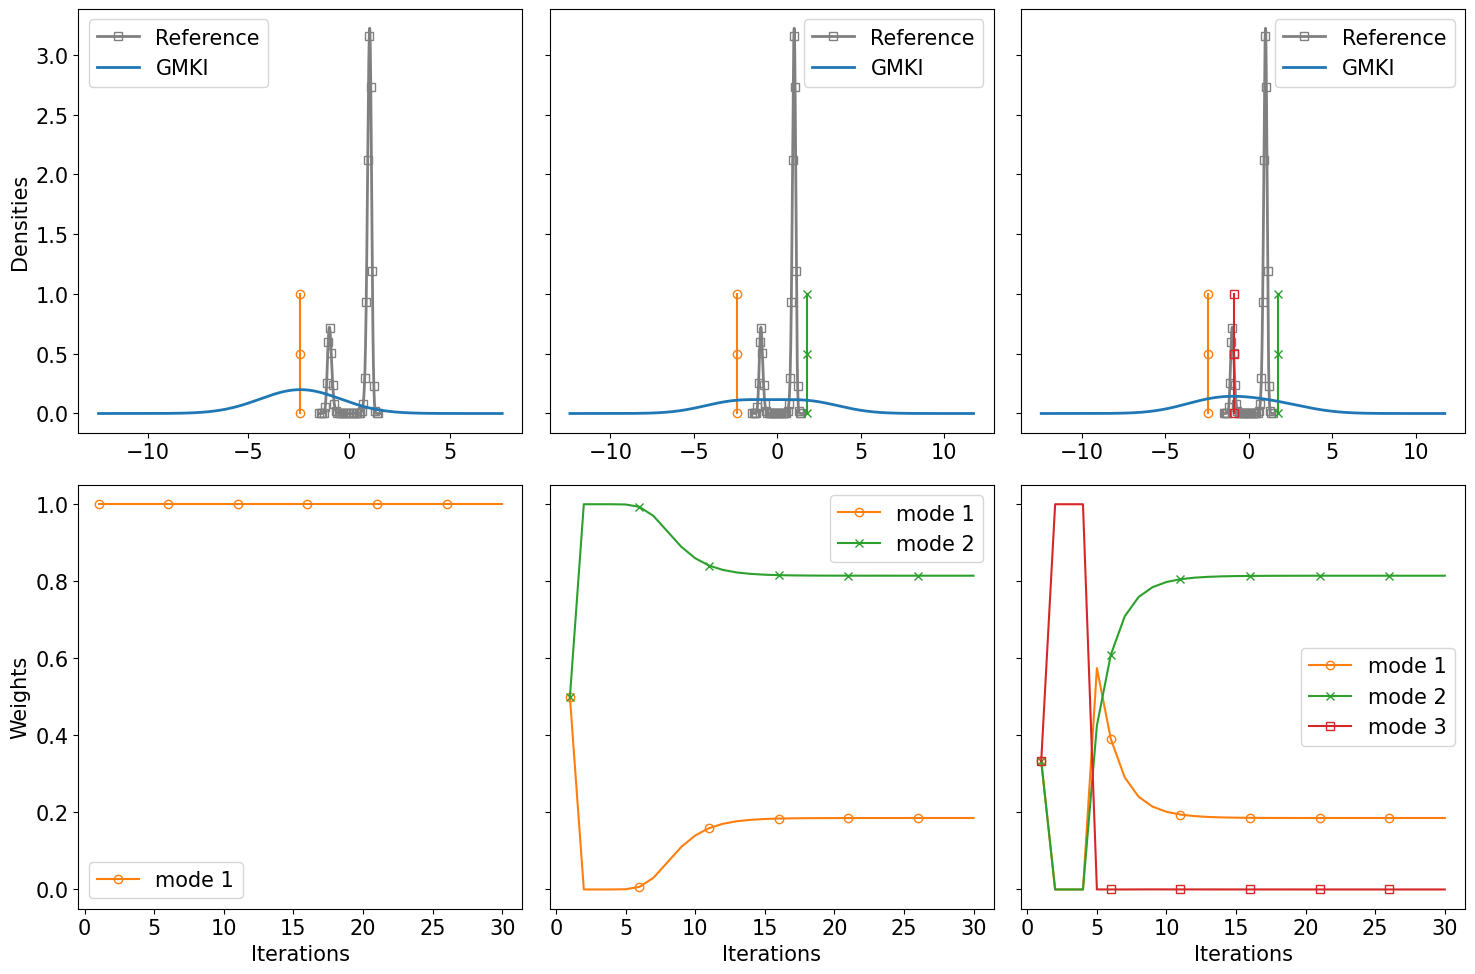

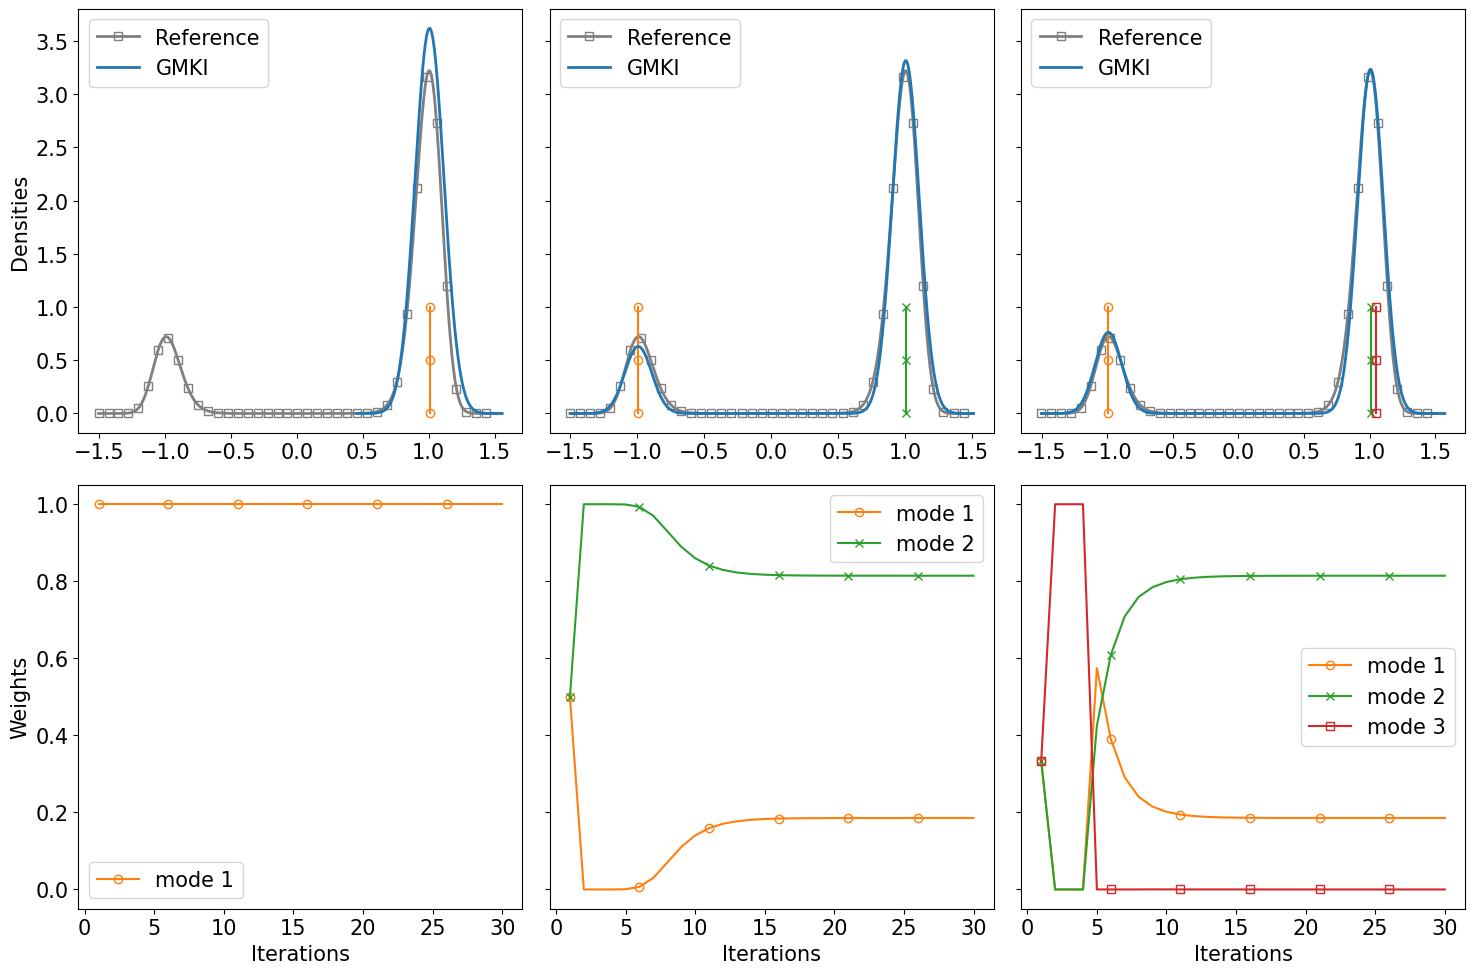

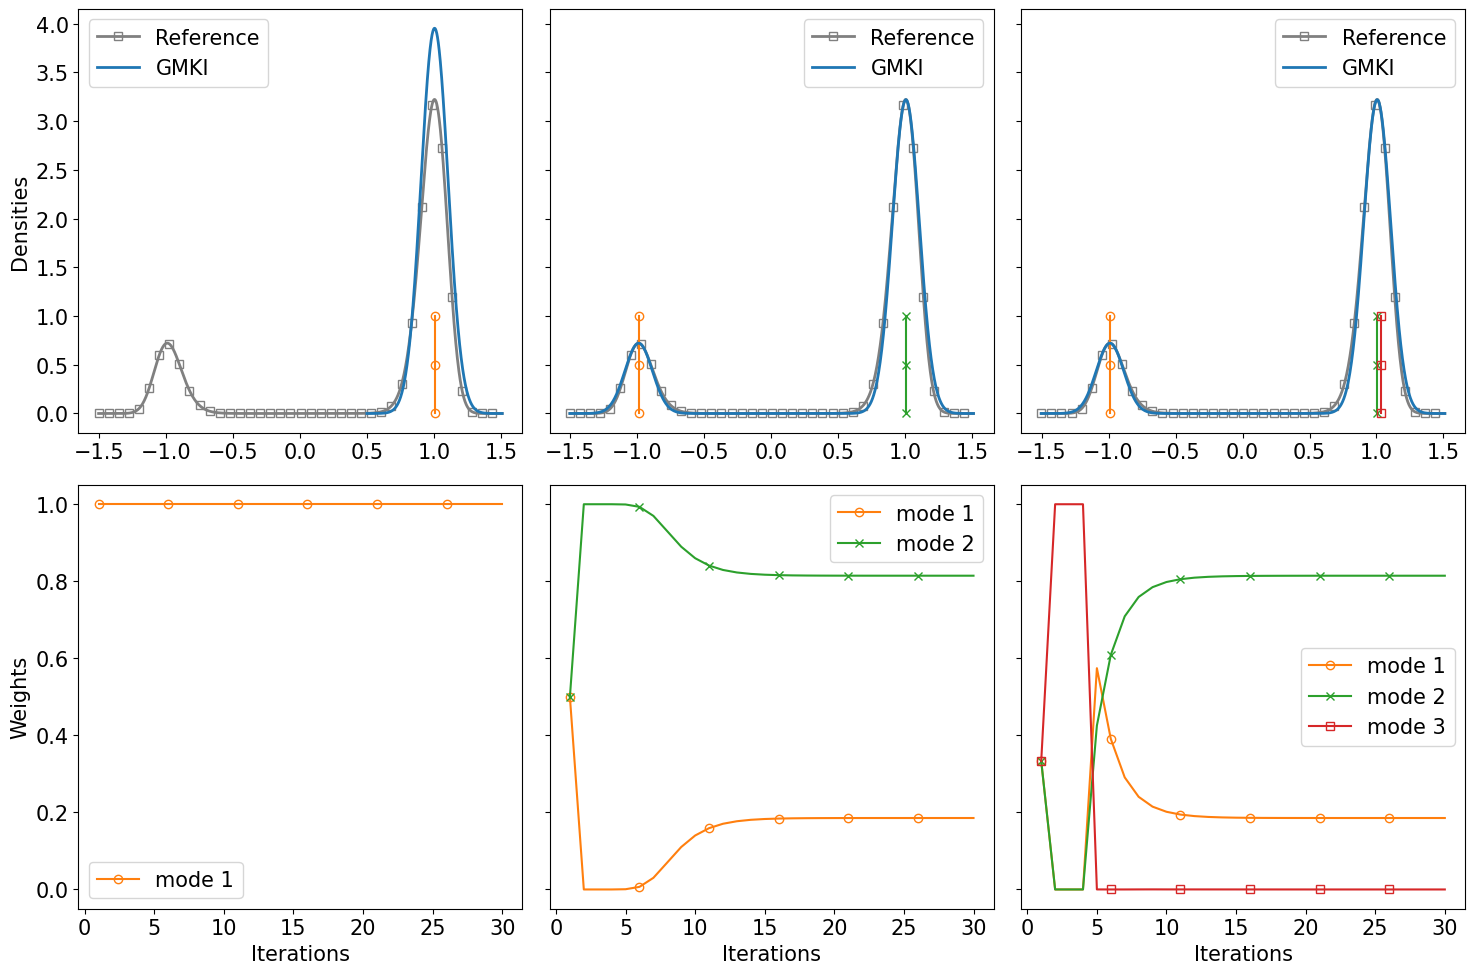

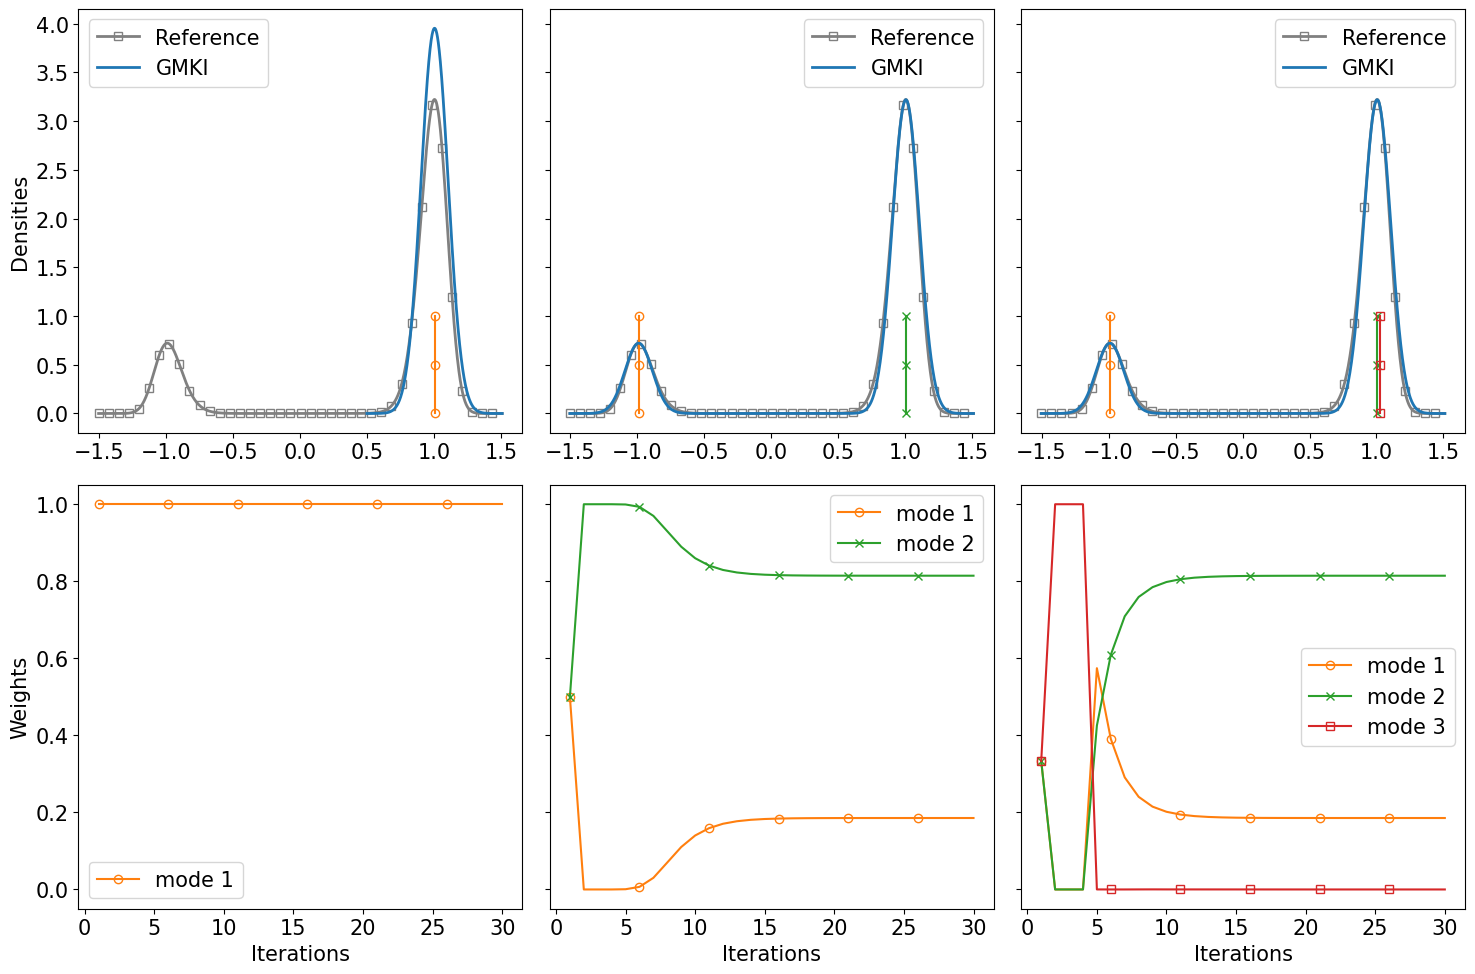

In [5]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.2, μ_0 = 3.0,  σ_0 = 2.0, Run_Fisher_Rao = false, plot_every = 5) 

┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82


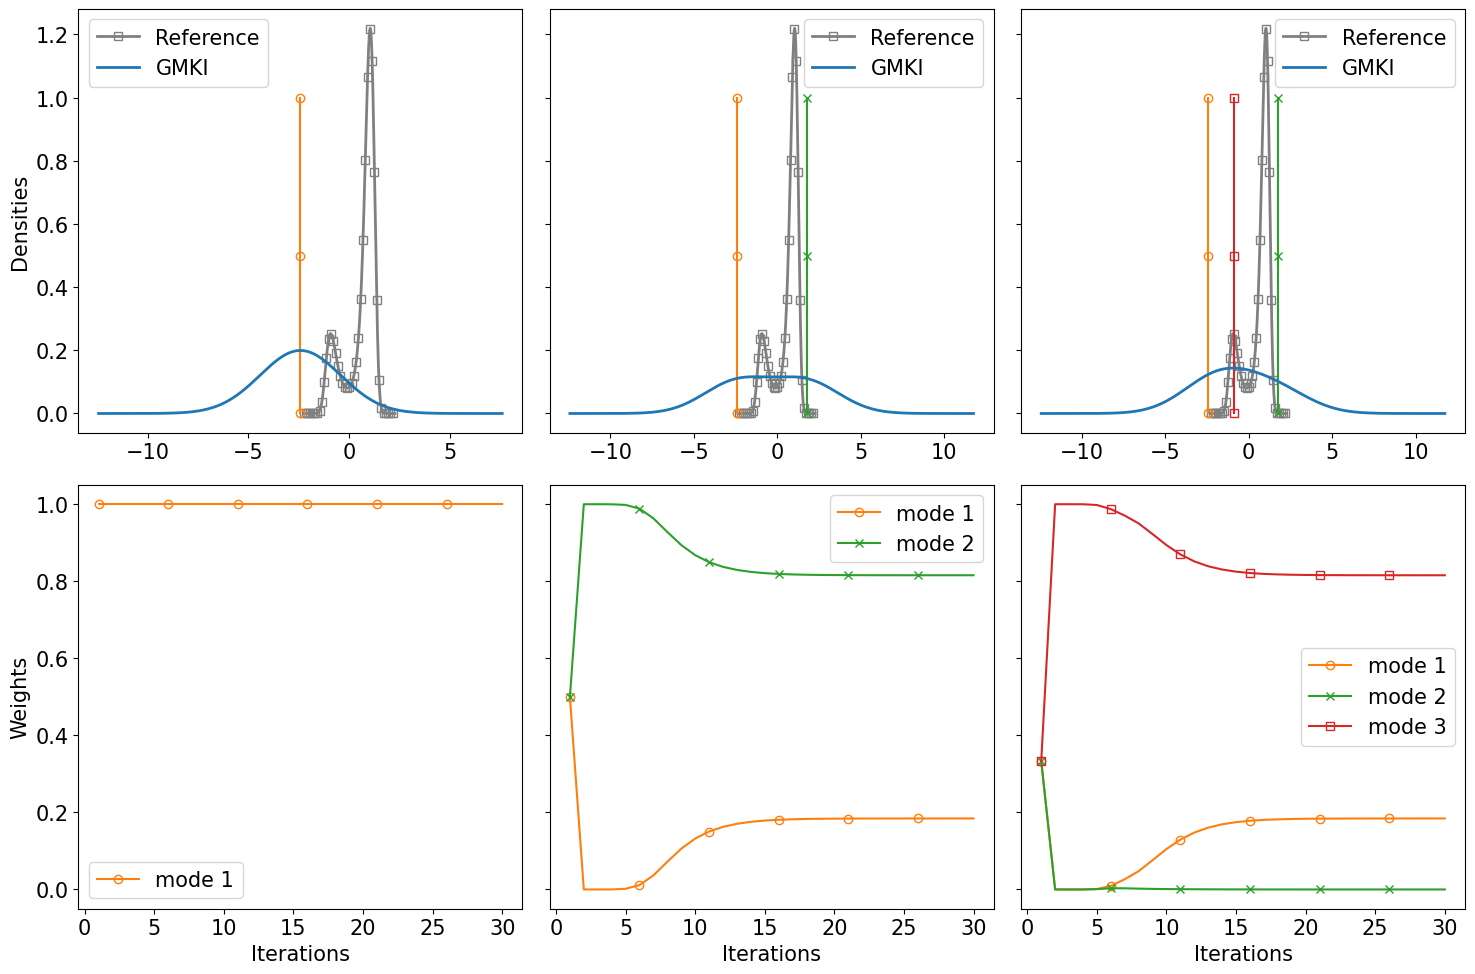

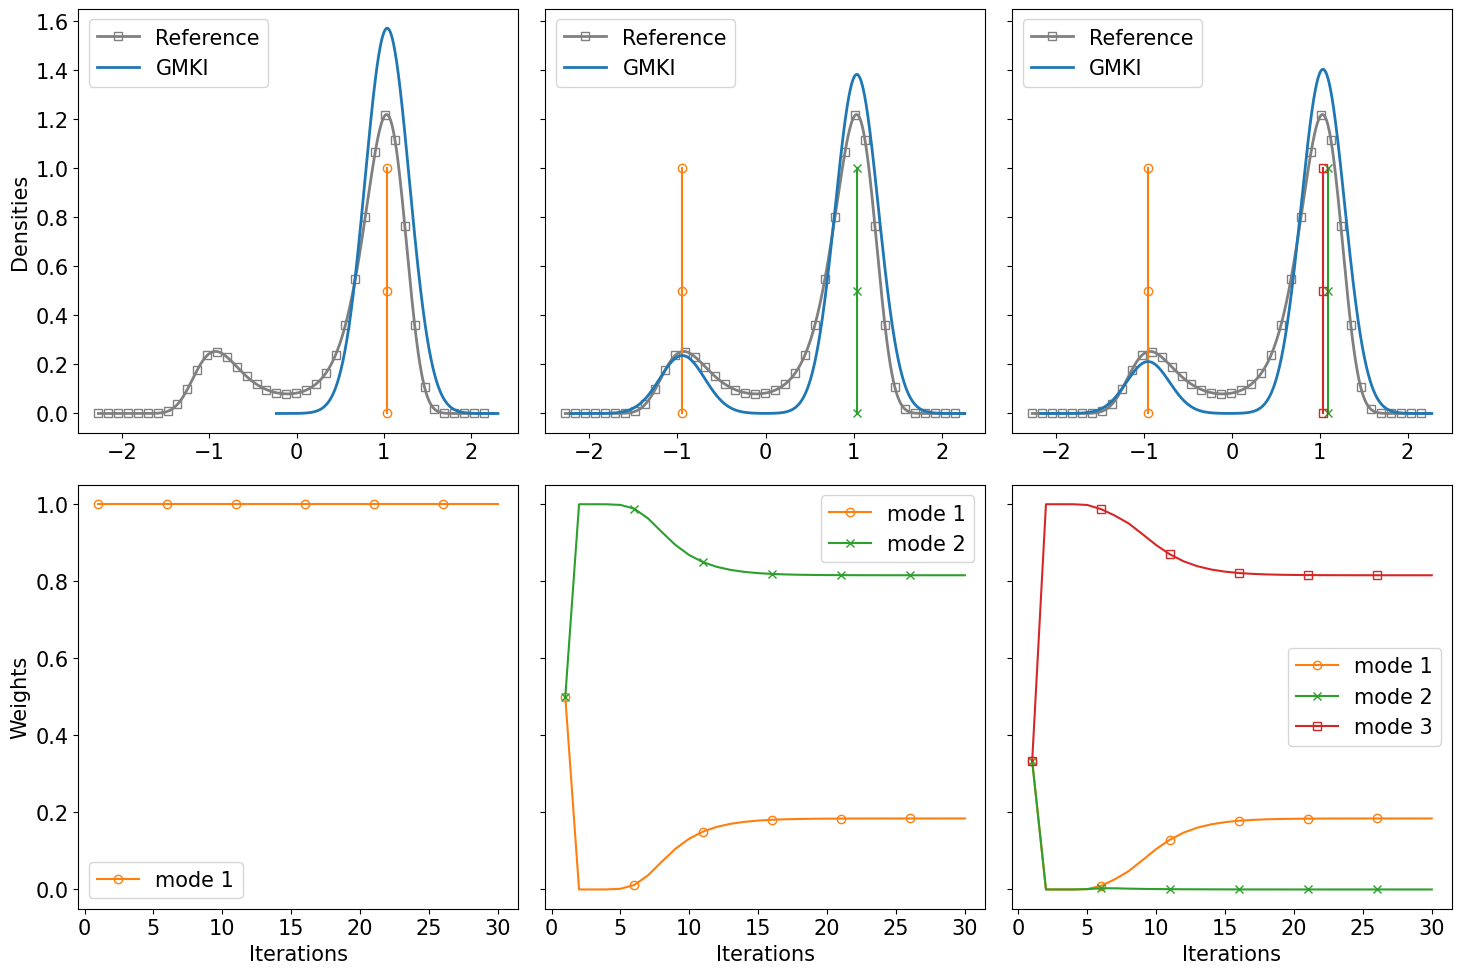

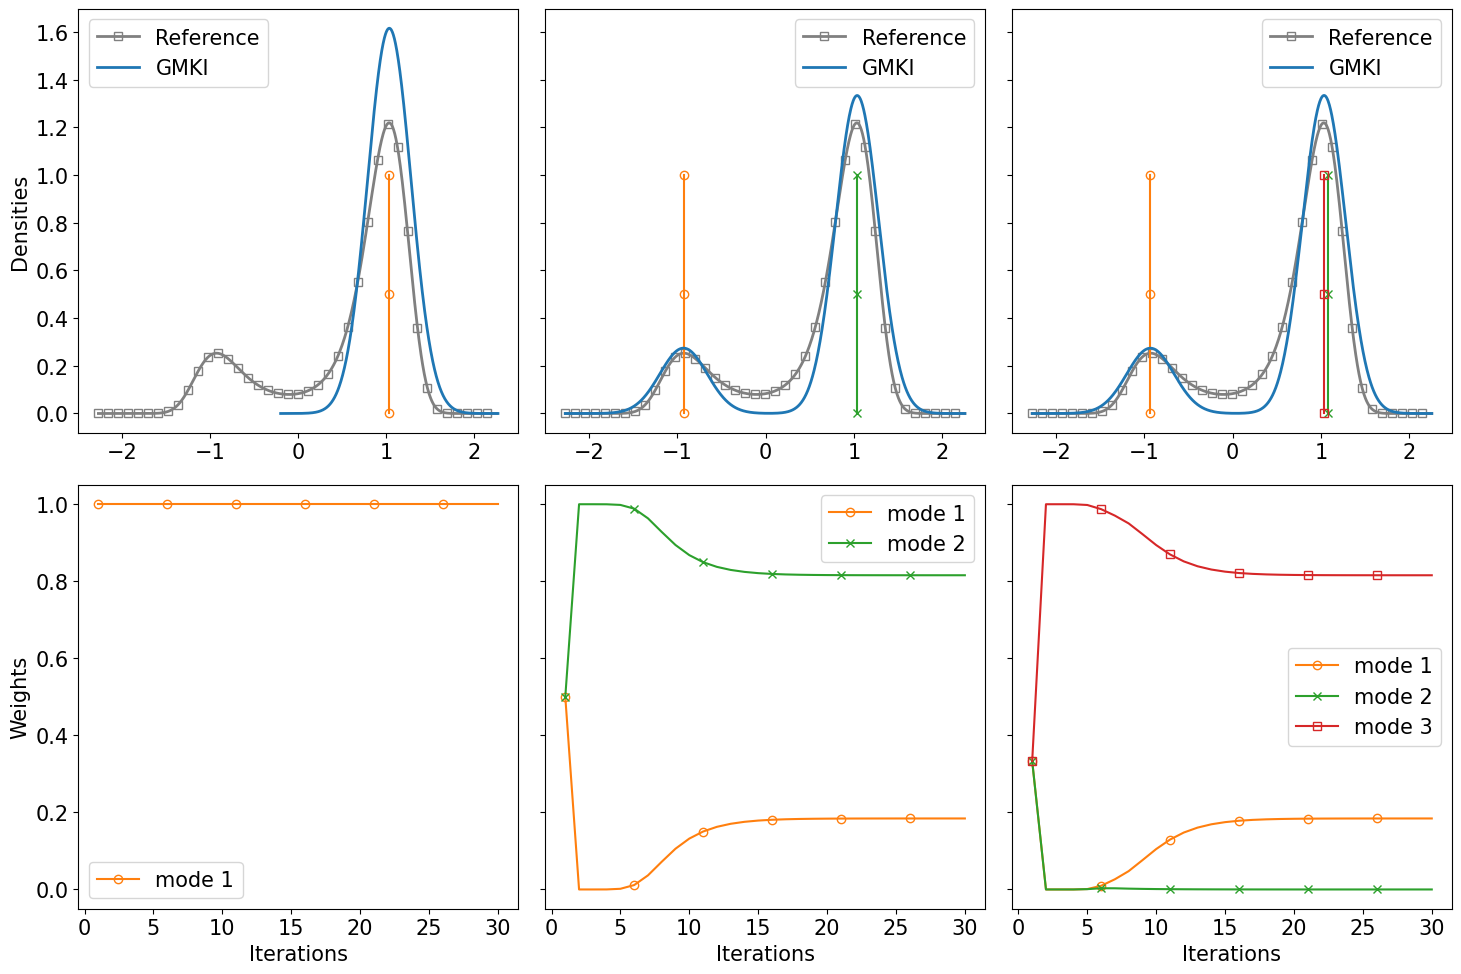

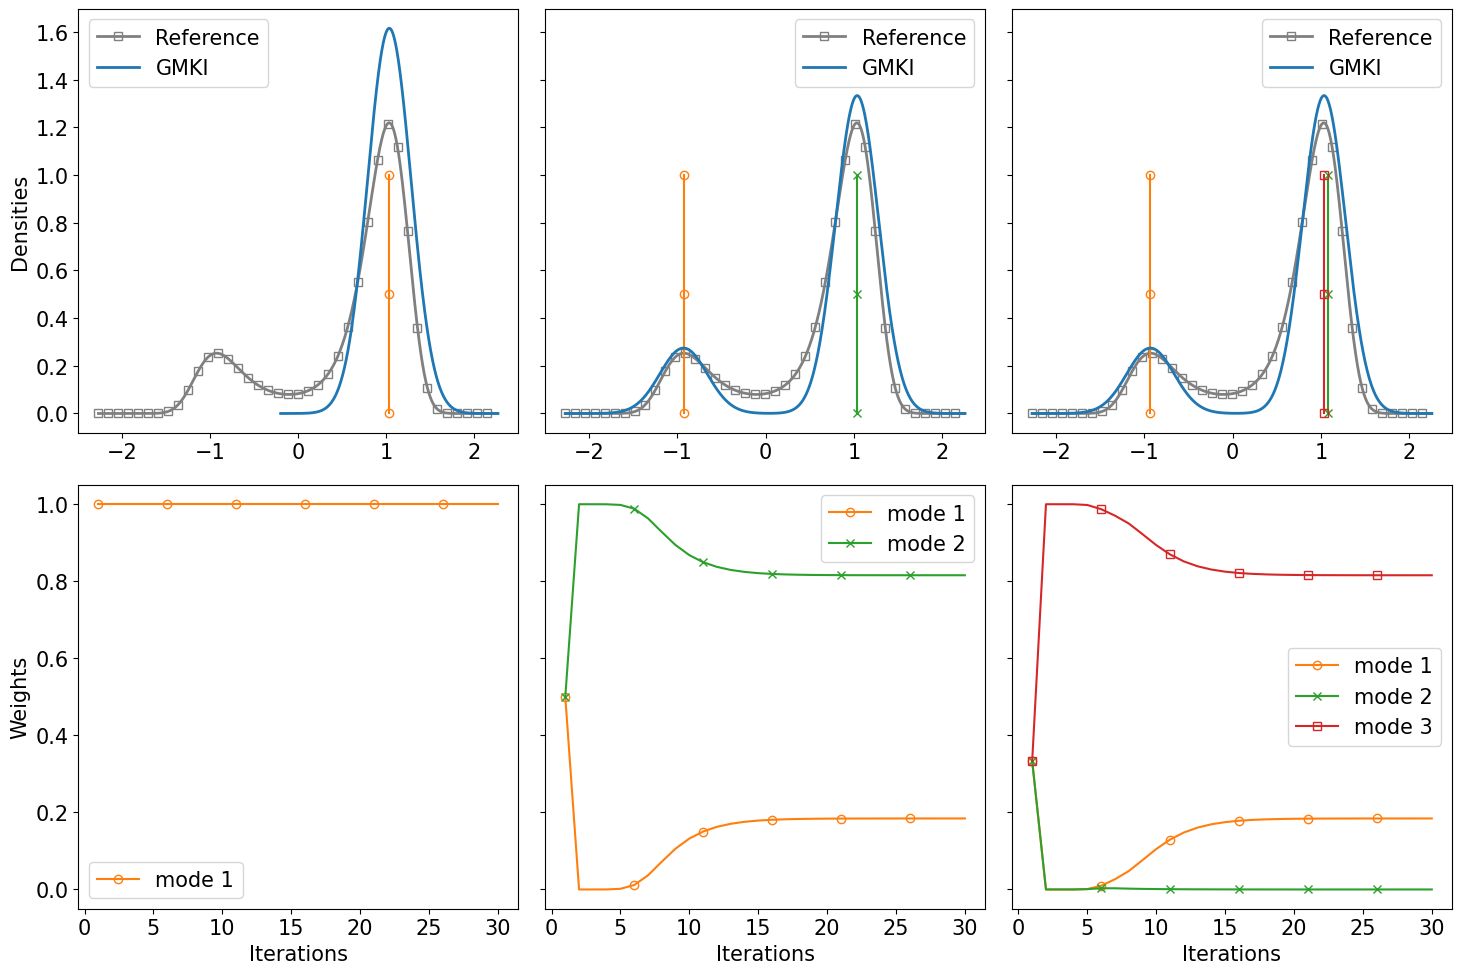

In [6]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 0.5, μ_0 = 3.2,  σ_0 = 2.0, Run_Fisher_Rao = false, plot_every = 5) 

┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82


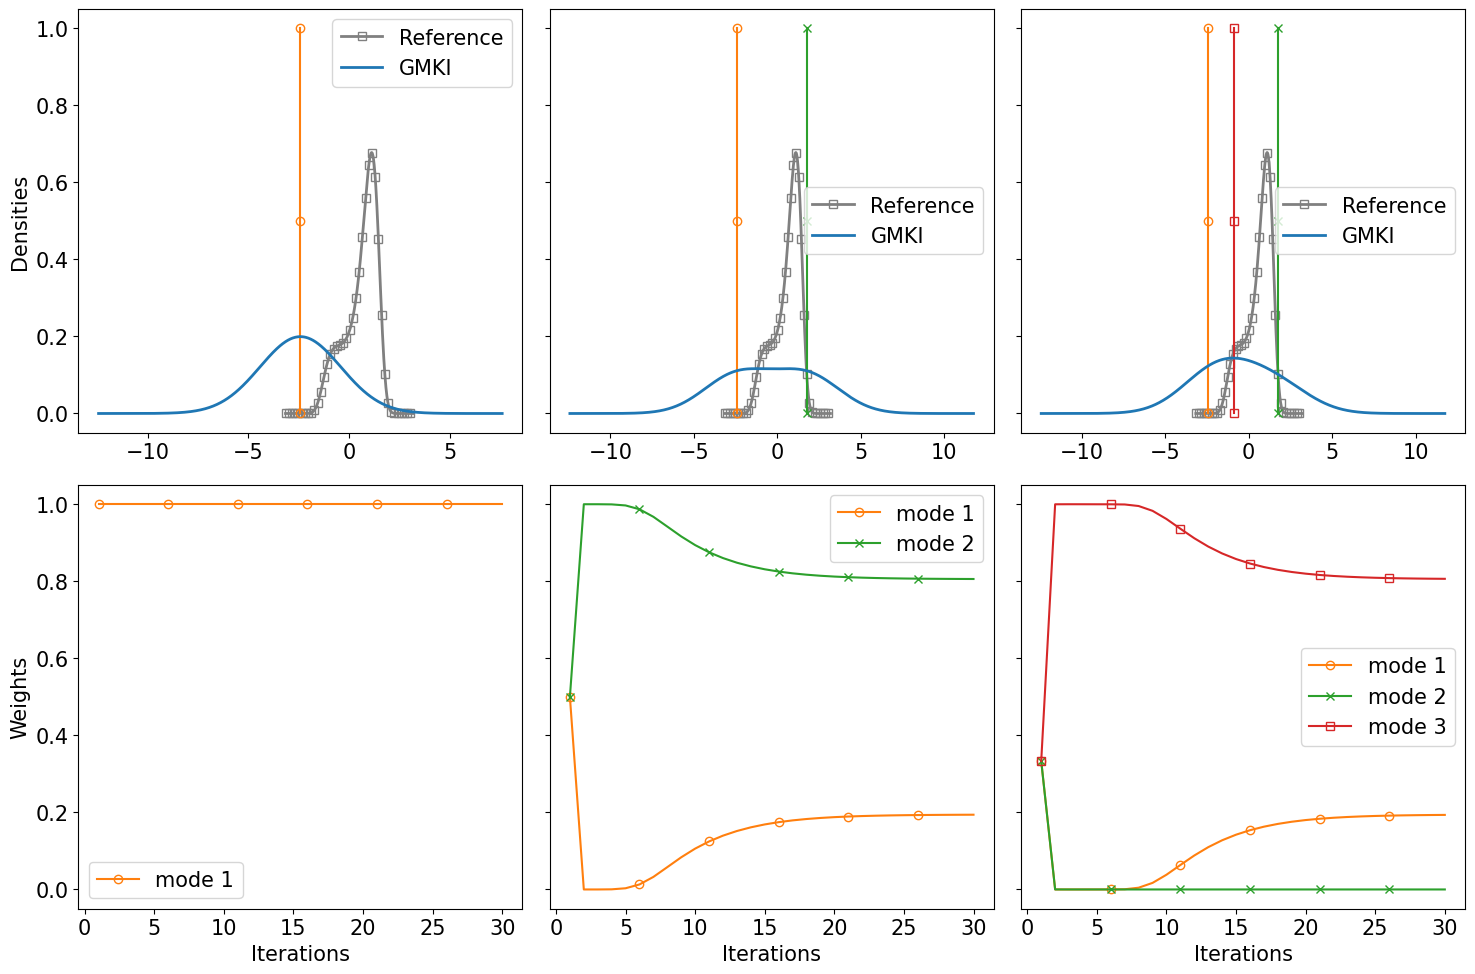

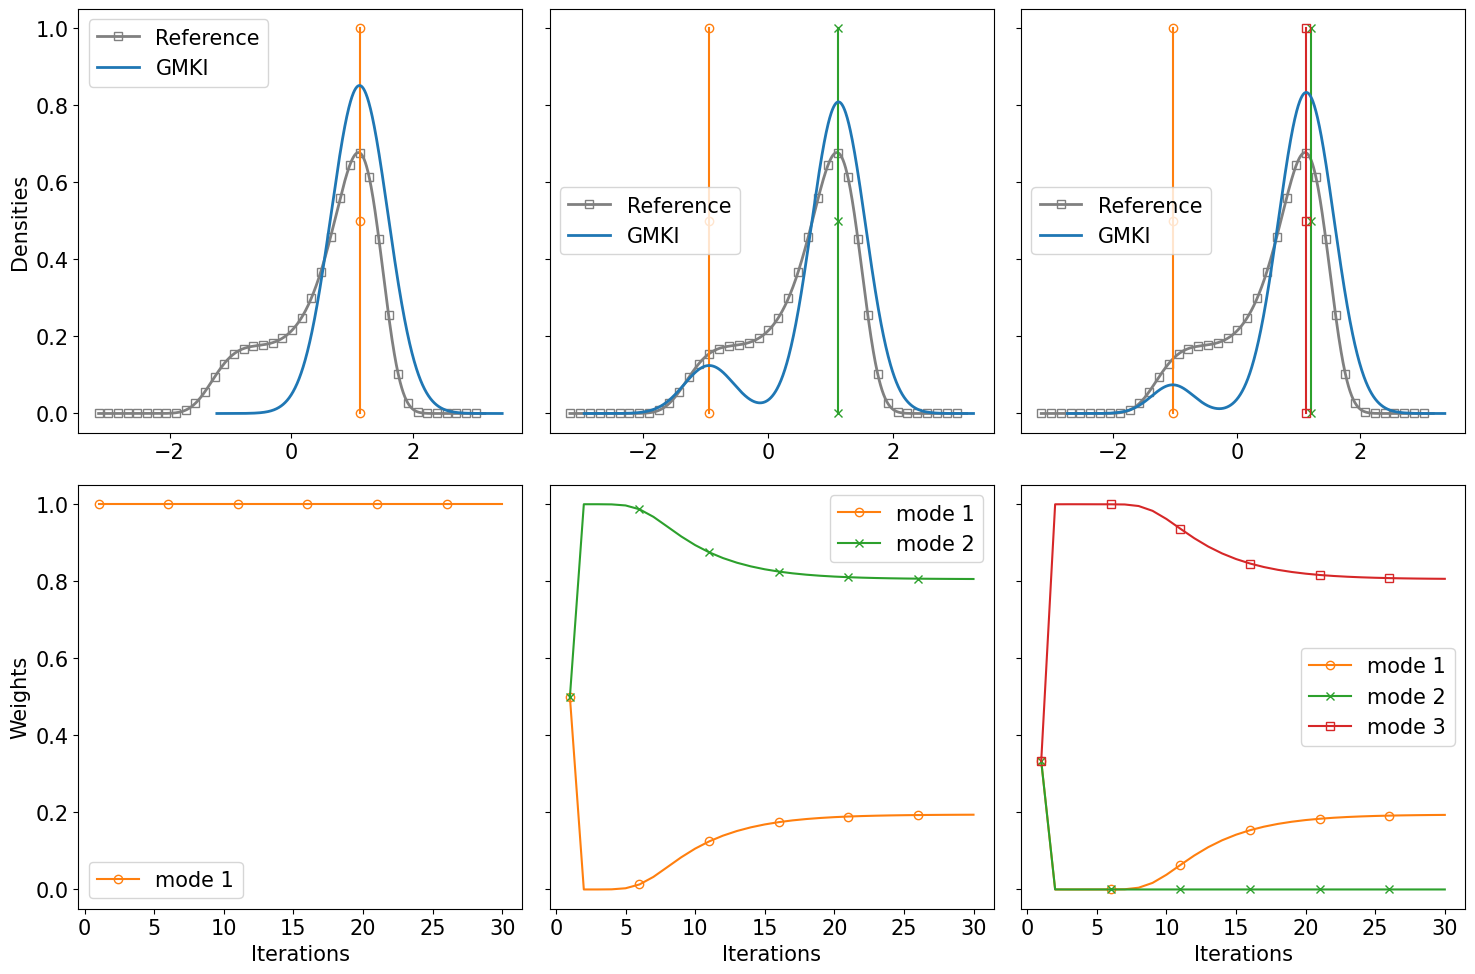

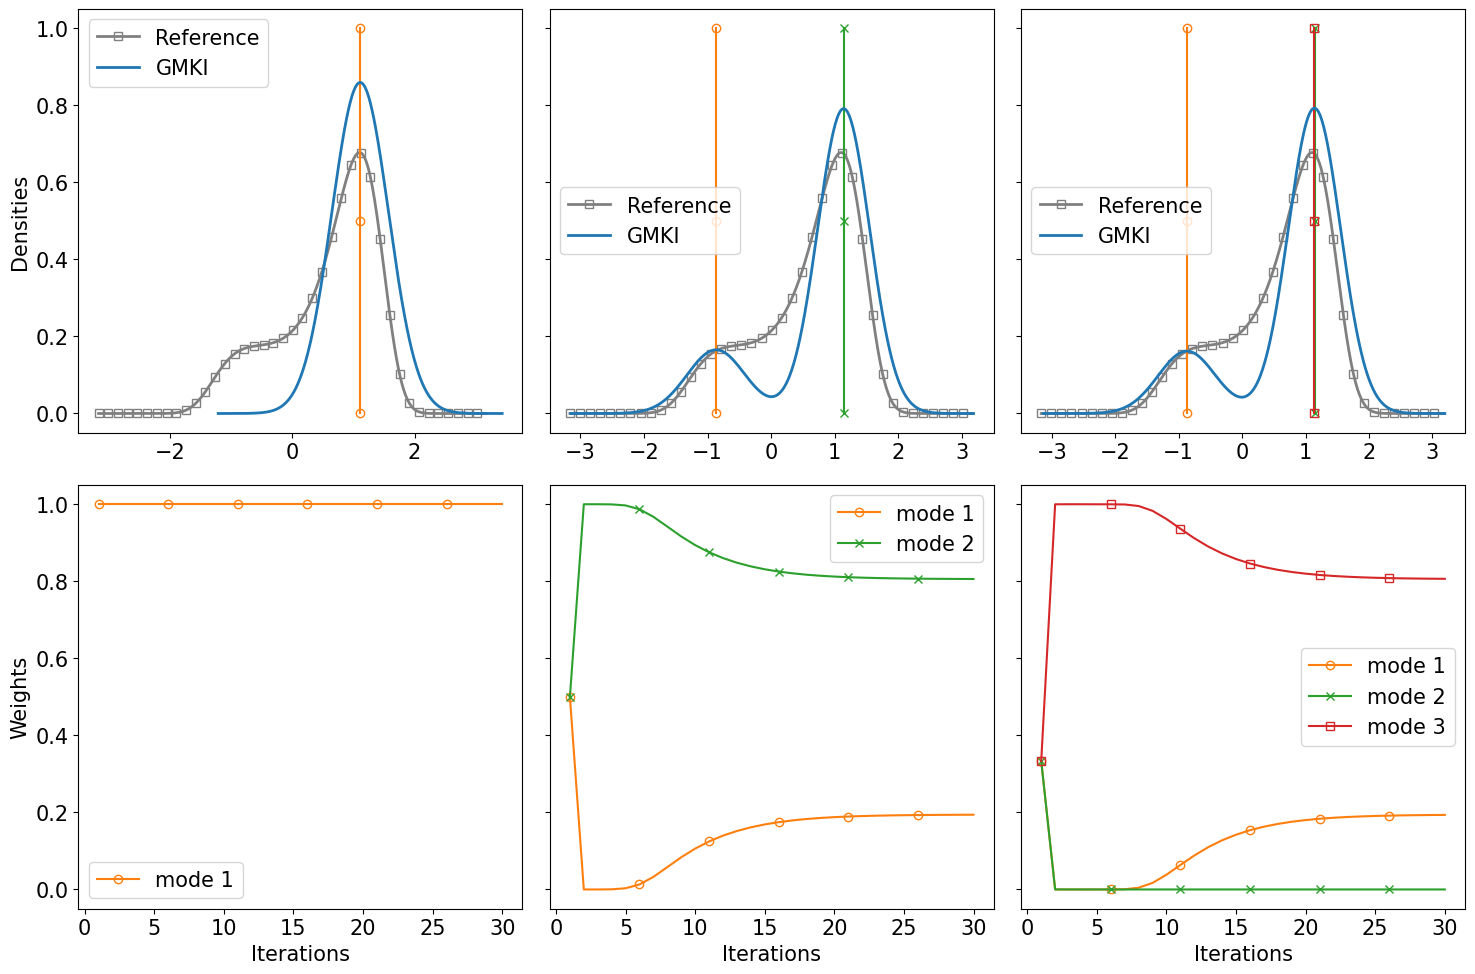

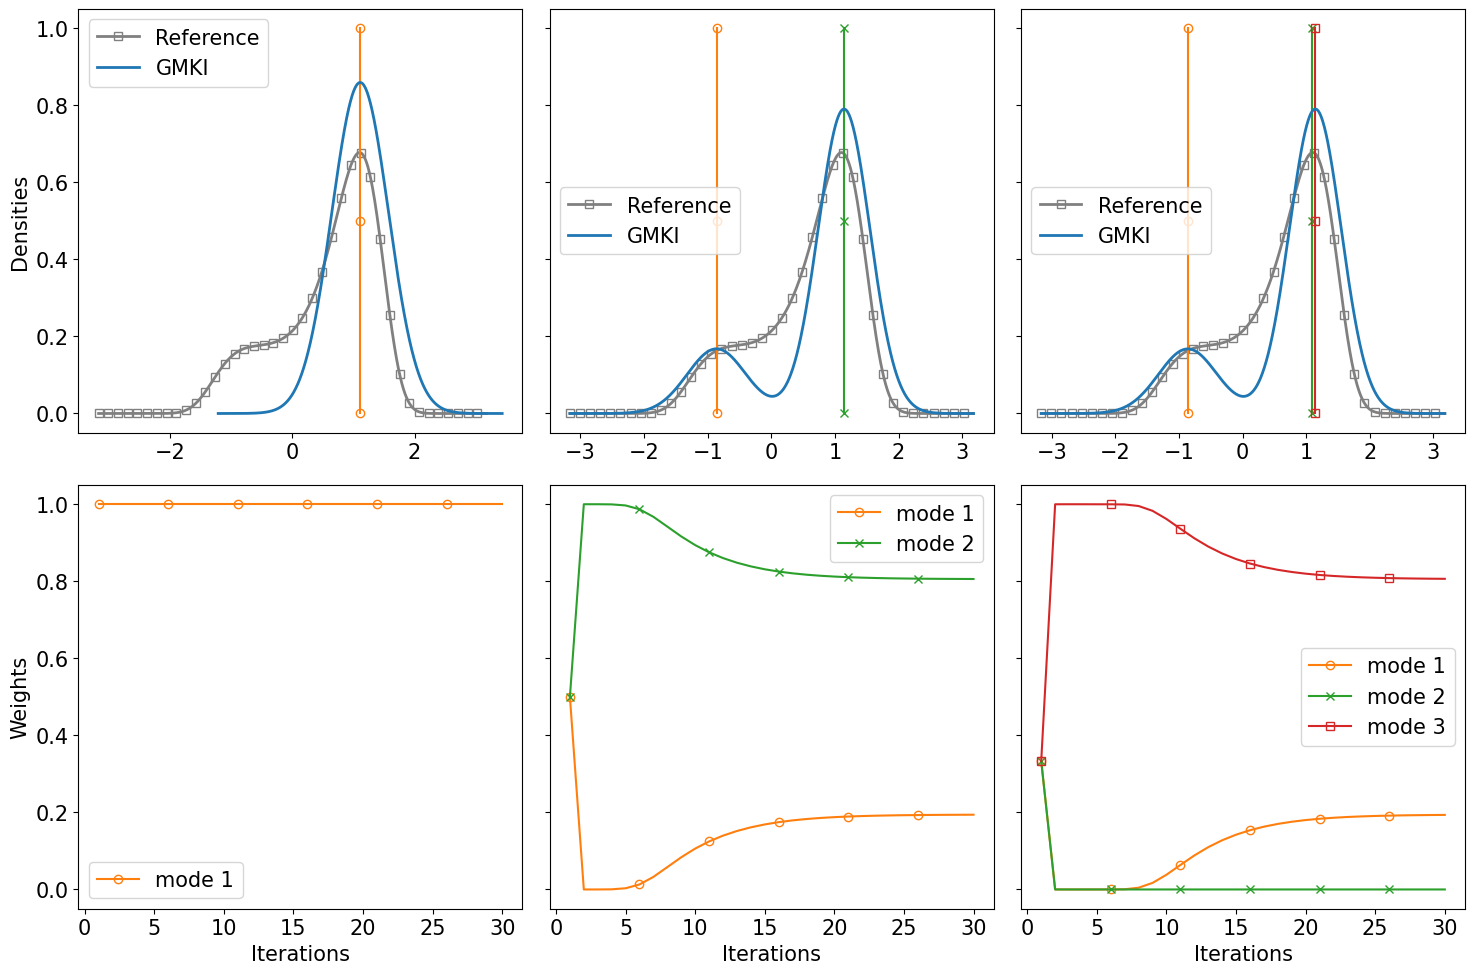

In [7]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.0, μ_0 = 3.0,  σ_0 = 2.0, Run_Fisher_Rao = false, plot_every = 5) 

┌ Info: ("Run GMKI with ", 1, " θ0_mean = ", [-2.4283140297584804;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82
┌ Info: ("Run GMKI with ", 2, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82
┌ Info: ("Run GMKI with ", 3, " θ0_mean = ", [-2.4283140297584804; 1.7456283123426095; -0.894645096090581;;])
└ @ Main In[3]:60
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:82


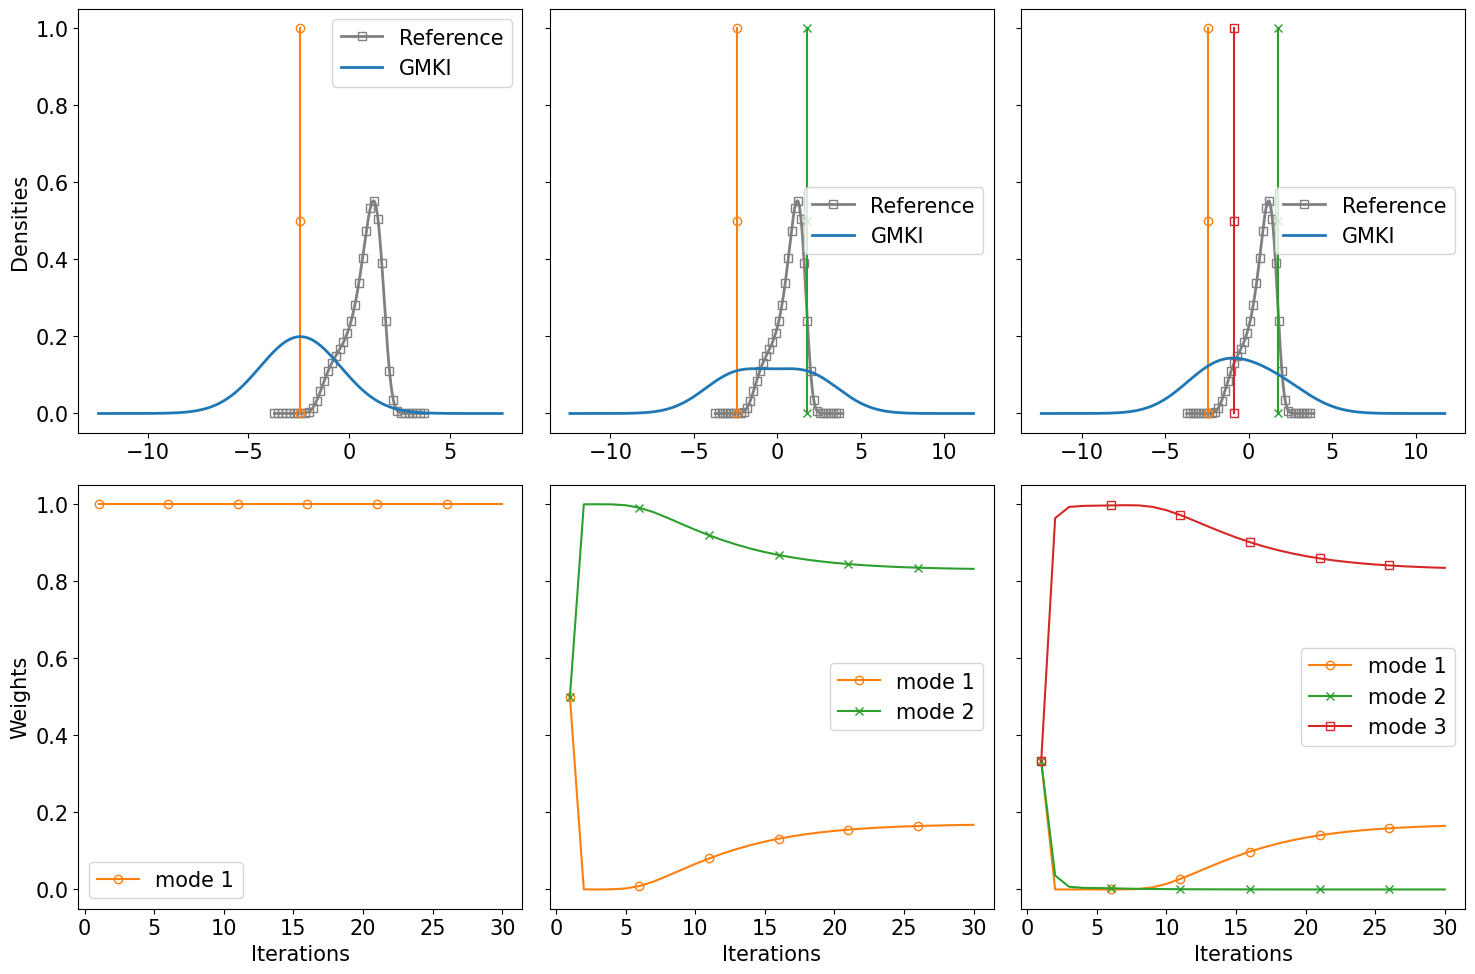

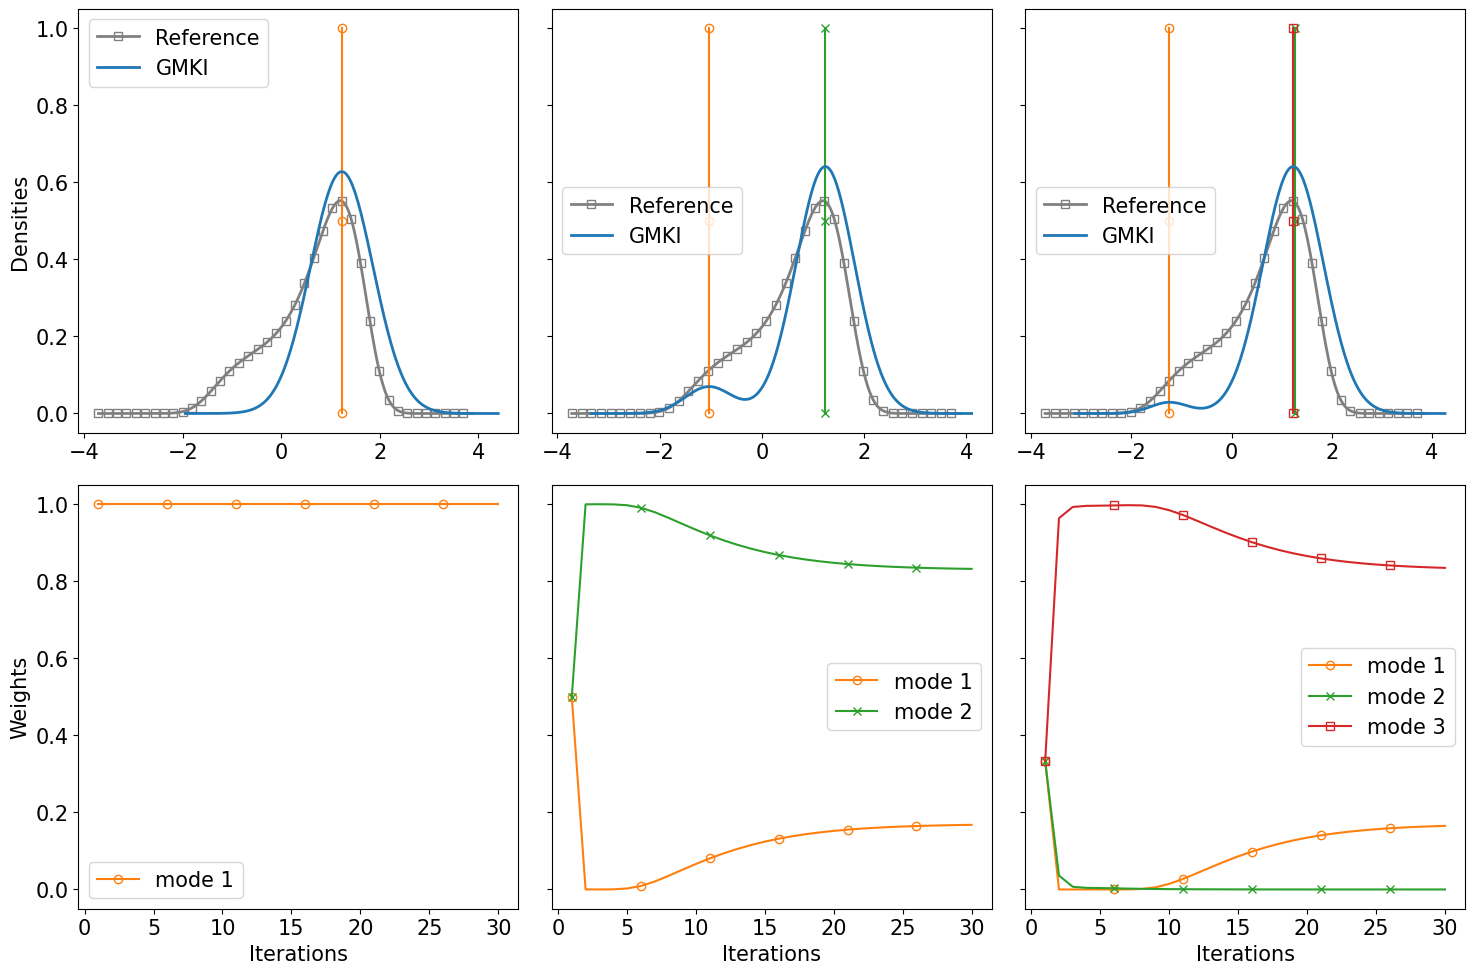

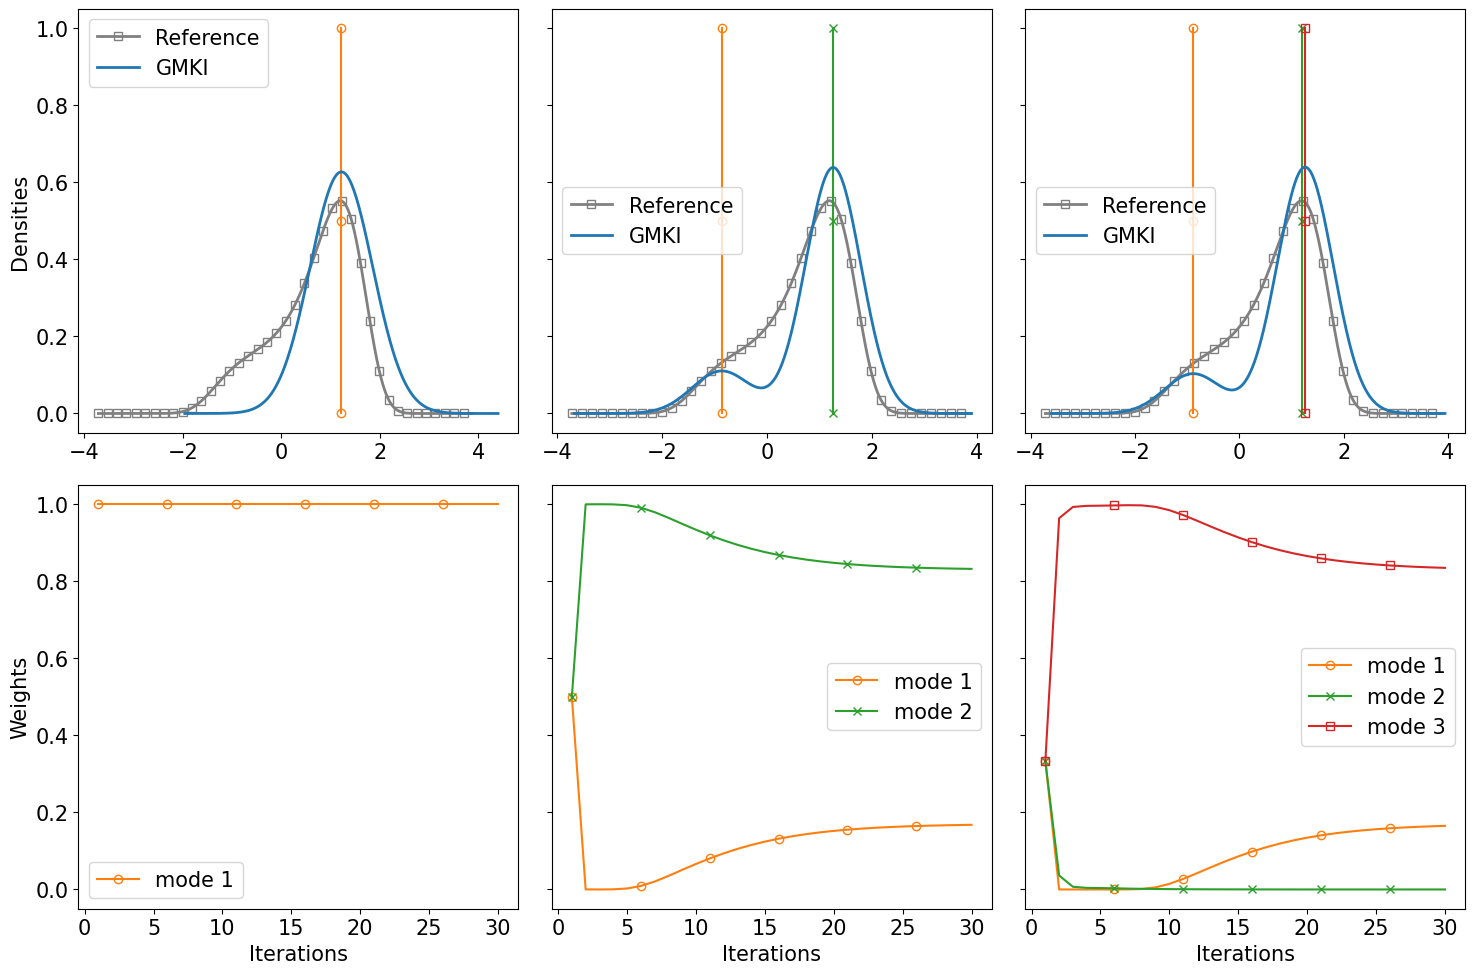

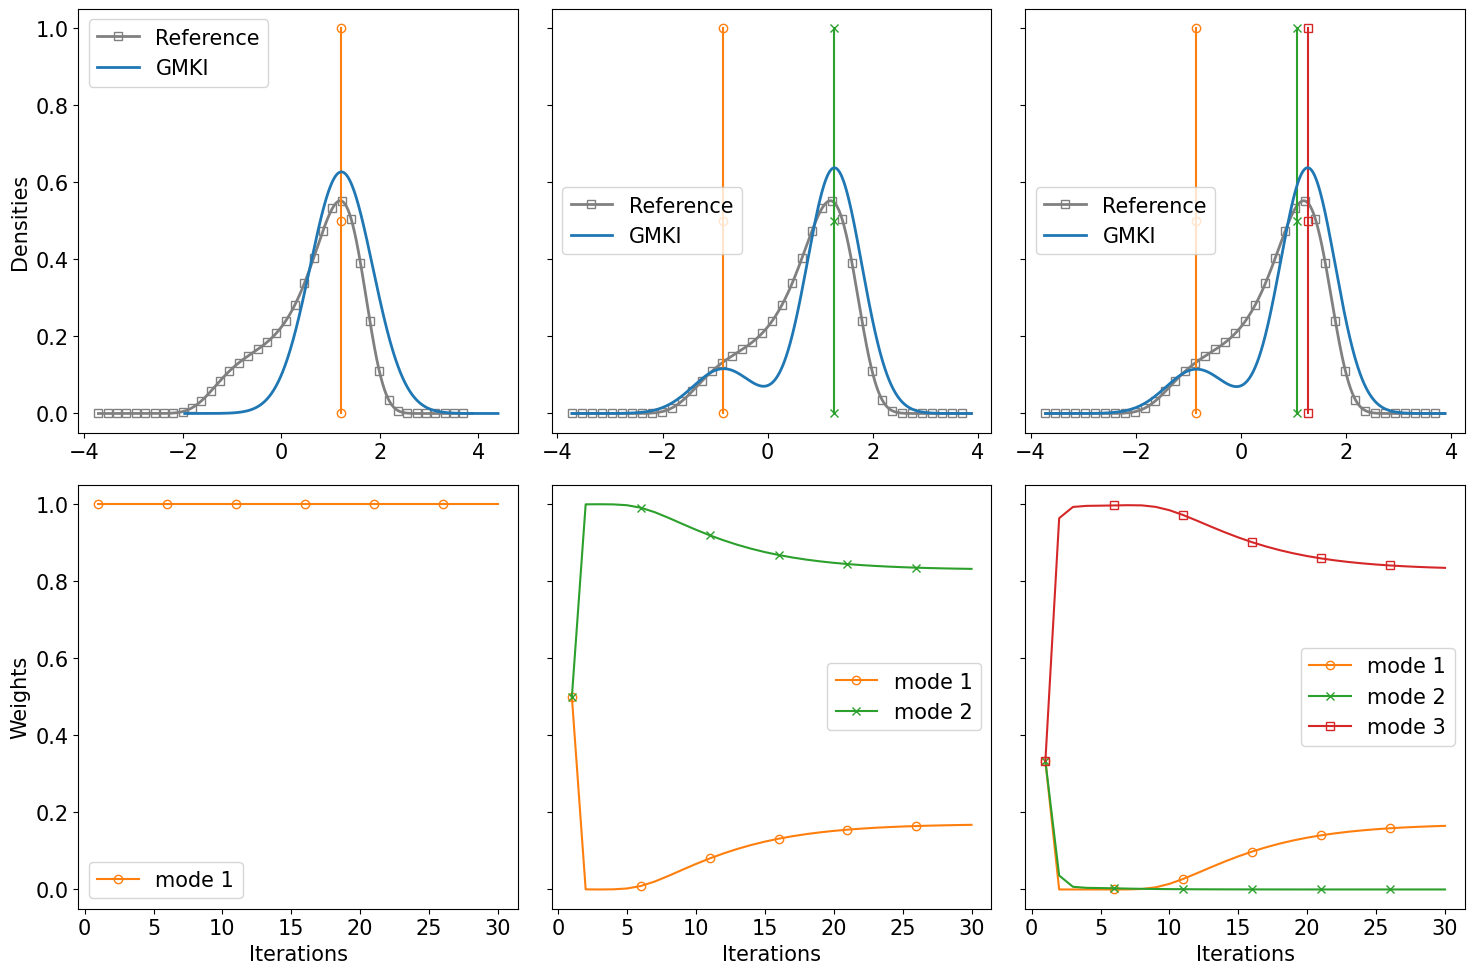

In [8]:
Posterior_Plot(p2; θ_ref = 1.0, σ_η = 1.5, μ_0 = 3.0,  σ_0 = 2.0, Run_Fisher_Rao = false, plot_every = 5) 

# Benchmark with Wasserstein Fisher-Rao

In [ ]:
Random.seed!(42)
######################### TEST #######################################
mutable struct Setup_Param{IT<:Int, VEC, MAT}
    N_θ::IT
    m_oo::VEC
    C_oo::MAT
end

function compute_∇logρ(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    C_oo, m_oo = s_param.C_oo, s_param.m_oo
    logρ   = -1/2*(θ - m_oo)'*(C_oo\(θ - m_oo))
    ∇logρ  = -C_oo\(θ - m_oo)
    # ∇²Φ = C_oo
    return logρ, ∇logρ
end


N_θ = 2
m_0 = [1.0; 1.0]
C_0 = [1/2 0; 0 2.0]



ϵs = [0.01, 0.1, 1]
fig, ax = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))
fig_cont, ax_cont = PyPlot.subplots(ncols=3, nrows=4, sharex="col", sharey=false, figsize=(12,12))

N_ens = 10
Δt = 0.001
N_t = 1000
ts = LinRange(0, Δt*N_t, N_t+1)
θ0 = Array(rand(MvNormal(m_0, C_0), N_ens)')
ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)







            

            

            ites = Array(0:N_t)
            markevery = div(N_t, 10)
            if (method  == "Wasserstein-Fisher-Rao" || method  == "Stein-Fisher-Rao")
                label = (preconditioner ? "Affine invariant "*method : method) * " GF"
                color = (method  == "Stein-Fisher-Rao" ? "C0" : "C1")
                if method  ==  "Wasserstein-Fisher-Rao" && ~preconditioner
                    color  = "C2"
                end
                if method  ==  "Stein-Fisher-Rao" && ~preconditioner
                    color  = "C3"
                end
                
                marker = (method  == "Stein-Fisher-Rao" ? "*" : "s")
            end
            linestyle = preconditioner ?  "solid" : "dotted"
            
            
            ax[1, test_id].semilogy(ts, ips_errors[:, 1], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            ax[2, test_id].semilogy(ts, ips_errors[:, 2], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            ax[3, test_id].semilogy(ts, ips_errors[:, 3], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            
            
            if (method == "Wasserstein-Fisher-Rao" && ~preconditioner)
                ax_cont[1, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            elseif (method == "Wasserstein-Fisher-Rao" && preconditioner)
                ax_cont[2, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            elseif (method == "Stein-Fisher-Rao" && ~preconditioner)
                ax_cont[3, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            else 
                ax_cont[4, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            end

        end
    end

    ax_cont[1, test_id].set_title(L"\lambda = " * string(ϵ))            
    ax[1, test_id].set_title(L"\lambda = " * string(ϵ))
    ax[1, test_id].set_xlabel("t")
    ax[2, test_id].set_xlabel("t")
    ax[3, test_id].set_xlabel("t")
    
    ax[1, test_id].grid("on")
    ax[2, test_id].grid("on")
    ax[3, test_id].grid("on")
    
    
    ax_cont[4,test_id].set_xlabel(L"\theta^{(1)}")
    
end

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=4)
ax[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")

fig.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
fig.savefig("Gaussian_gd_particle_converge.pdf")


ax_cont[1, 1].set_ylabel("Wasserstein-Fisher-Rao GF")
ax_cont[2, 1].set_ylabel("Affine invariant Wasserstein-Fisher-Rao  GF")
ax_cont[3, 1].set_ylabel("Stein-Fisher-Rao  GF")
ax_cont[4, 1].set_ylabel("Affine invariant Stein-Fisher-Rao  GF")
fig_cont.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
fig_cont.savefig("Gaussian_gd_particle_contour.pdf")
